# Hate Speech Detector 2.0
---
**Best classifiers testing**
1. Load best models of each classification method.
2. Perform multilabel classification task with each of models.
3. Put results: accuracy, precision, recall anf F measure for each of hate-speech classes and overall into table.
4. Get classification model with F measure for overall postive examples. Winner model.
5. Compare project results with results from literature.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.dataframes.utils import combine_row_wisely, shuffle_dataframe, models_quality_results
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class

from src.best_models import NAMES, TYPES, SHORT_NAMES, PARAMETERS, CLF_CLASSES, CLF_KWARGS
from src.constants import (DUPLICATED_PATH,
                           POC_SCORES_PATH, TOPIC_POC_SCORES_PATH, OTHER_SCORES_PATH, LEMMAS_PATH,
                           LABELS,
                           BEST_CHART_DIR, RESULTS_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
plt.style.use('ggplot')

There are several types of classification. First **lexical** bases only on POC (Phrase Occurence Coefficient) features. Second **simple machine learning** uses classifiers like: Decision Tree or Random Forest which may use POC features as well as vectorized texts. Third type **simple deep learning** uses simple neural networks (Dense 1D Convolutional or Recurrent). The more complex neural networks (ex. 1d Convolutional + LSTM) denote **complex deep learning** classification. **Advanced deep learning** classification are neural networks with improved hyperparameter (i.e. optimizers with regularizers and learning rate schedulers).

## Data loading

### Classes

In [4]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Tweet POC scores for each class

In [5]:
df_poc_scores = pd.read_csv(POC_SCORES_PATH).drop(['id'], axis=1)
df_poc_scores.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,pon_POC_max,styg_POC_min,styg_POC_mean,styg_POC_max,szan_POC_min,szan_POC_mean,szan_POC_max,vulg_POC_min,vulg_POC_mean,vulg_POC_max
0,0.000000,0.000000,0.0,-0.5,-0.002193,0.5,0.0,0.000000,0.000000,0.0,...,0.5,-0.5,0.000260,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.333333,0.004526,0.5,-0.5,0.000808,0.5,0.0,0.006219,0.333333,-0.5,...,0.5,-0.5,-0.004606,0.333333,0.0,0.0,0.0,0.0,0.0,0.0


### Tweet topic POC for each class

In [6]:
df_topic_poc_scores = pd.read_csv(TOPIC_POC_SCORES_PATH).drop(['id'], axis=1)
df_topic_poc_scores.head(2)

,wyz_topic_POC_min,wyz_topic_POC_mean,wyz_topic_POC_max,groz_topic_POC_min,groz_topic_POC_mean,groz_topic_POC_max,wyk_topic_POC_min,wyk_topic_POC_mean,wyk_topic_POC_max,odcz_topic_POC_min,...,pon_topic_POC_max,styg_topic_POC_min,styg_topic_POC_mean,styg_topic_POC_max,szan_topic_POC_min,szan_topic_POC_mean,szan_topic_POC_max,vulg_topic_POC_min,vulg_topic_POC_mean,vulg_topic_POC_max
0,0.0,0.000000,0.000000,-0.052632,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,...,0.052632,-0.052632,0.002632,0.052632,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.005263,0.052632,-0.052632,-0.010526,0.000000,-0.052632,-0.002632,0.052632,-0.052632,...,0.000000,-0.052632,-0.010526,0.052632,0.0,0.0,0.0,0.0,0.0,0.0


### Tweet other scores

In [7]:
df_other_scores = pd.read_csv(OTHER_SCORES_PATH).drop(['id'], axis=1)
df_other_scores.head(2)

,s_neg,s_neu,s_pos,n_chars,n_sylls,n_words,nu_words,nl_chars,nl_sylls,nl_words,nlu_words
0,0,6,1,36,15,7,7,35,13,7,7
1,1,18,1,94,38,18,18,88,33,16,16


### Lexical combined data

In [8]:
unused_fields = ['vulg_POC_min', 'vulg_POC_mean', 'vulg_POC_max']

df_lex_data = combine_row_wisely([df_poc_scores.drop(unused_fields, axis=1), df_classes])
df_lex_data = shuffle_dataframe(df_lex_data)
df_lex_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,szan_POC_min,szan_POC_mean,szan_POC_max,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
11004,-0.5,-0.002611,0.0,-0.5,-0.002193,0.333333,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
6590,0.0,0.000000,0.0,-0.5,0.000115,1.000000,0.0,0.013267,0.5,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


### Simple feature ML combined data

In [9]:
df_simpleML_data = combine_row_wisely([df_poc_scores, df_topic_poc_scores, df_other_scores, df_classes])
df_simpleML_data = shuffle_dataframe(df_simpleML_data)
df_simpleML_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,nl_sylls,nl_words,nlu_words,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
3301,0.0,0.0,0.0,-0.5,-0.005194,0.0,0.0,0.0,0.0,0.0,...,41,20,20,0,0,0,0,0,0,0
10473,0.0,0.0,0.0,-0.5,-0.001177,0.2,0.0,0.0,0.0,0.0,...,13,7,7,0,0,0,0,0,0,0


### Lemmatized tweets

In [10]:
df_lemmatized = pd.read_csv(LEMMAS_PATH).drop(['id'], axis=1)
df_lemmatized.head(2)

,lemmatized
0,w czwartek musieć poprawić sąd i trybunał
1,żale nałęcz i riposta macierewicz pan być w ko...


### Lemmatized combined data

In [11]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,lemmatized,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
4620,polski sąd zły w ue czas to zmienić,0,0,0,0,0,0,0
6994,oleć bo móc sąd do zaorać,0,0,0,0,0,0,0


## Best models loading and running

In [12]:
y_preds = list([])

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


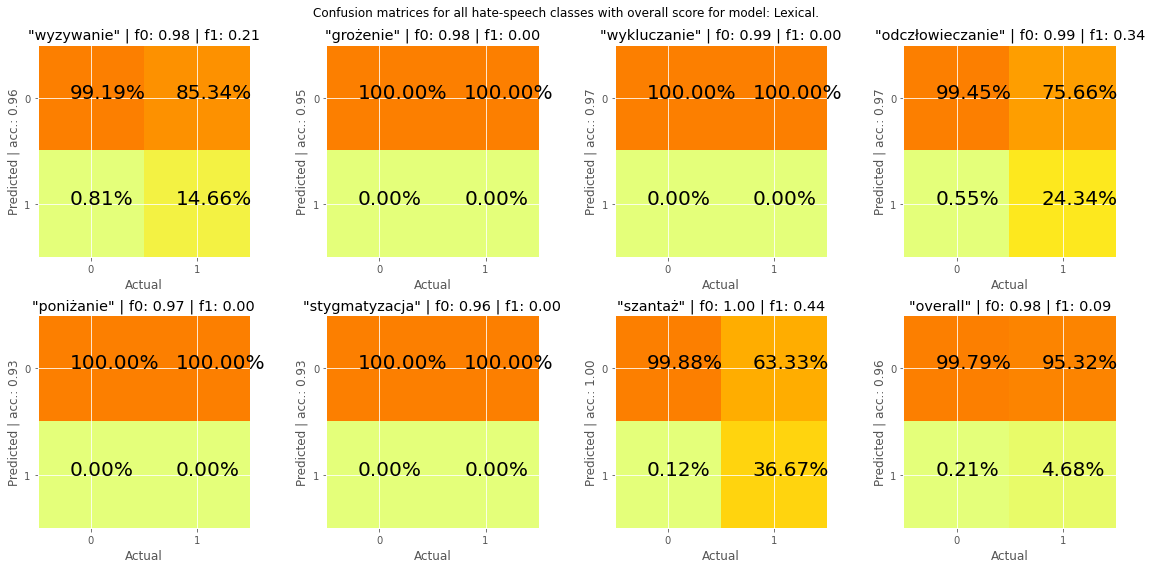

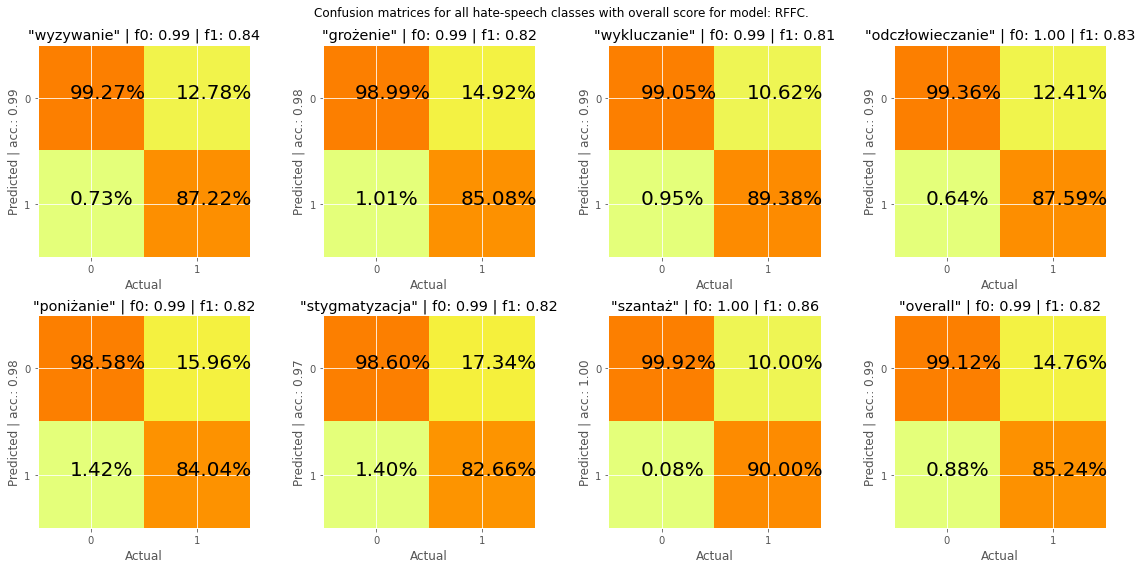

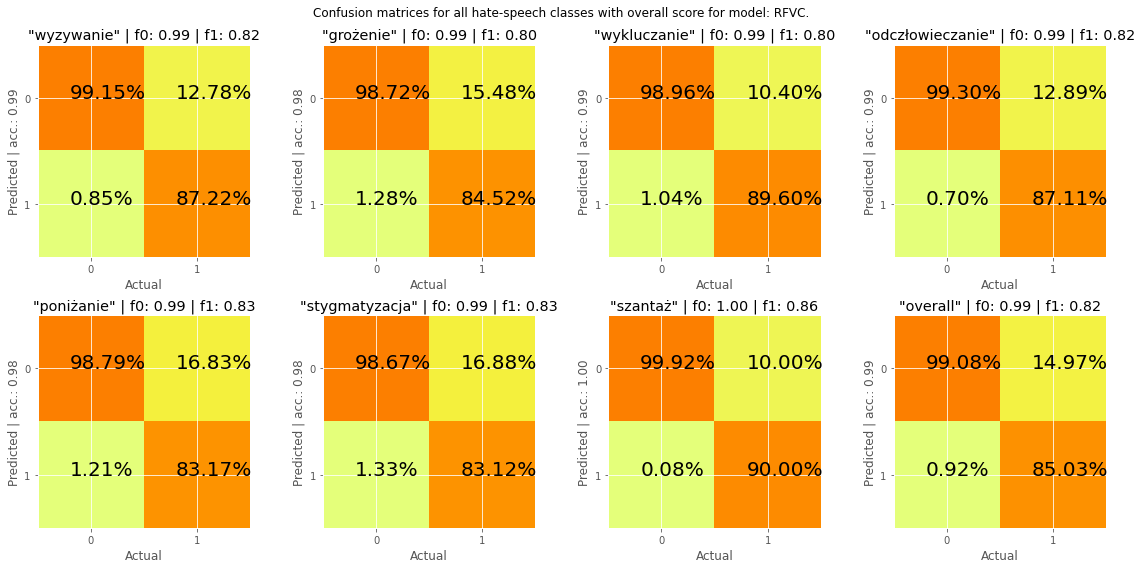

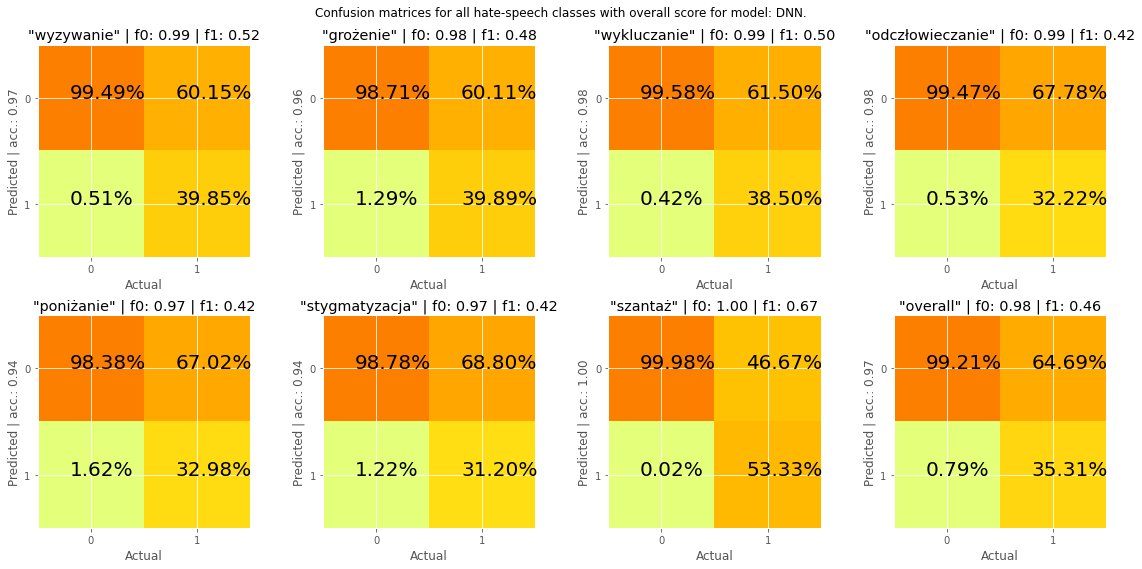

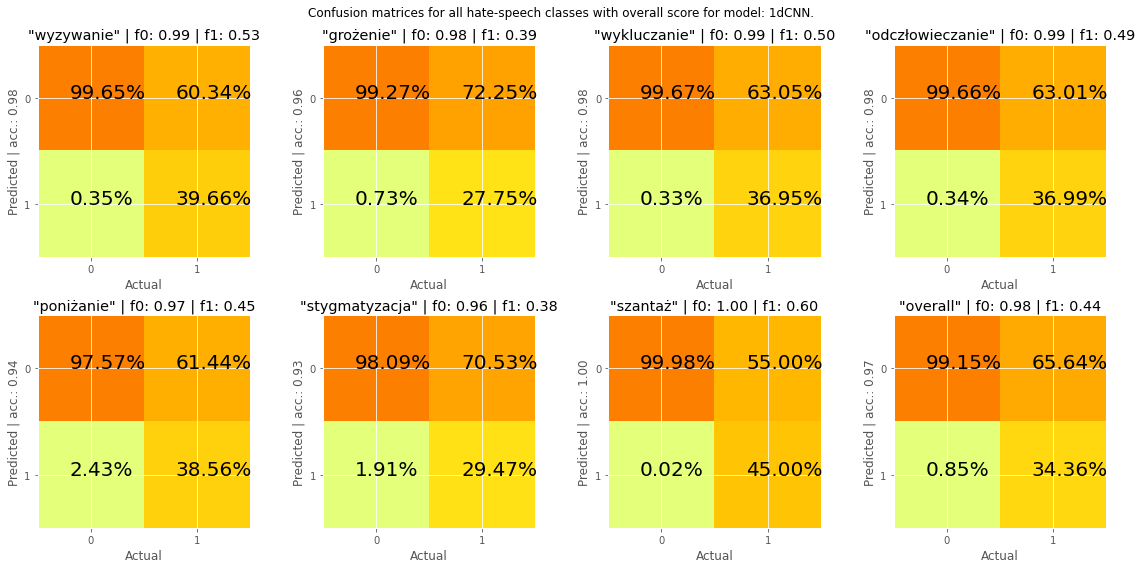

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


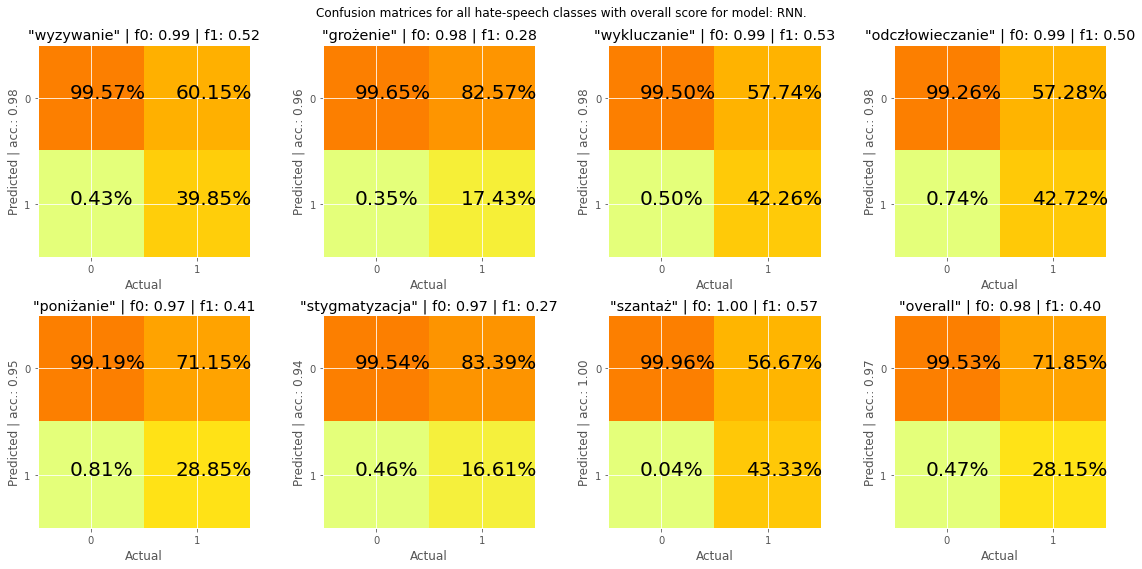

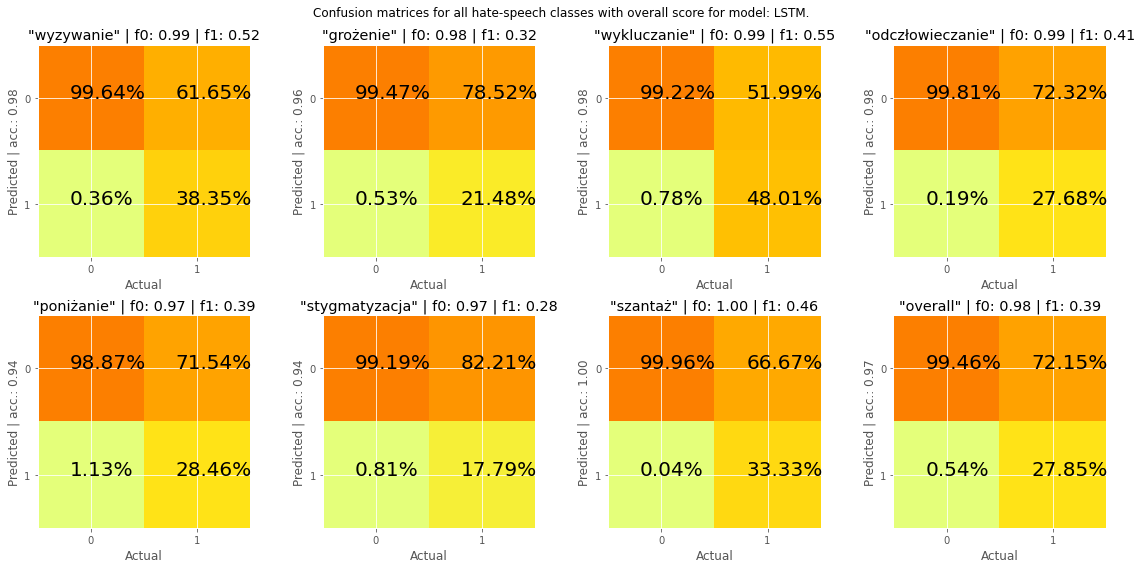

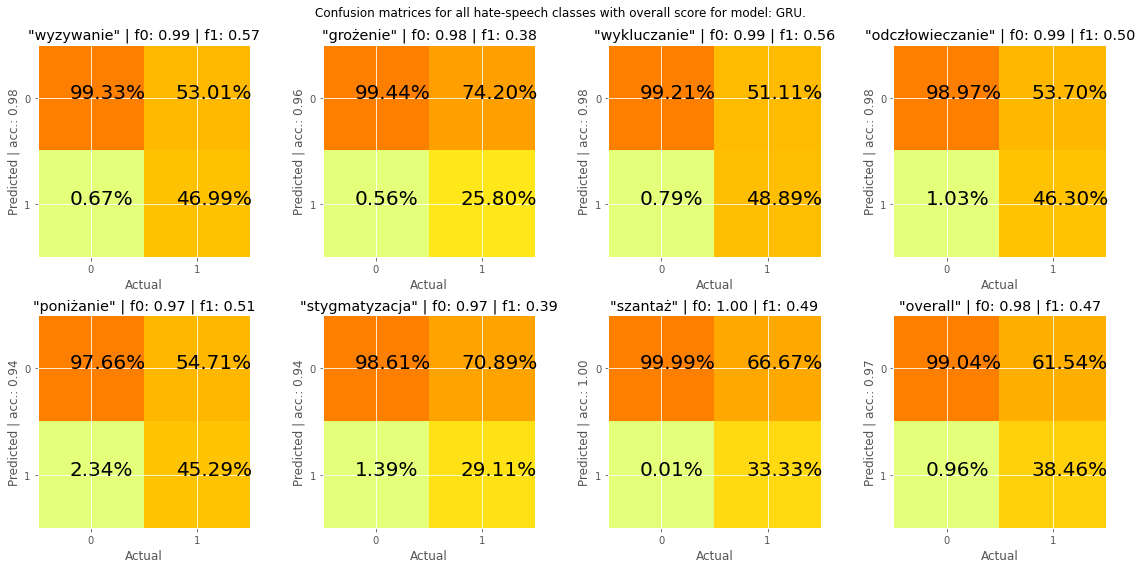

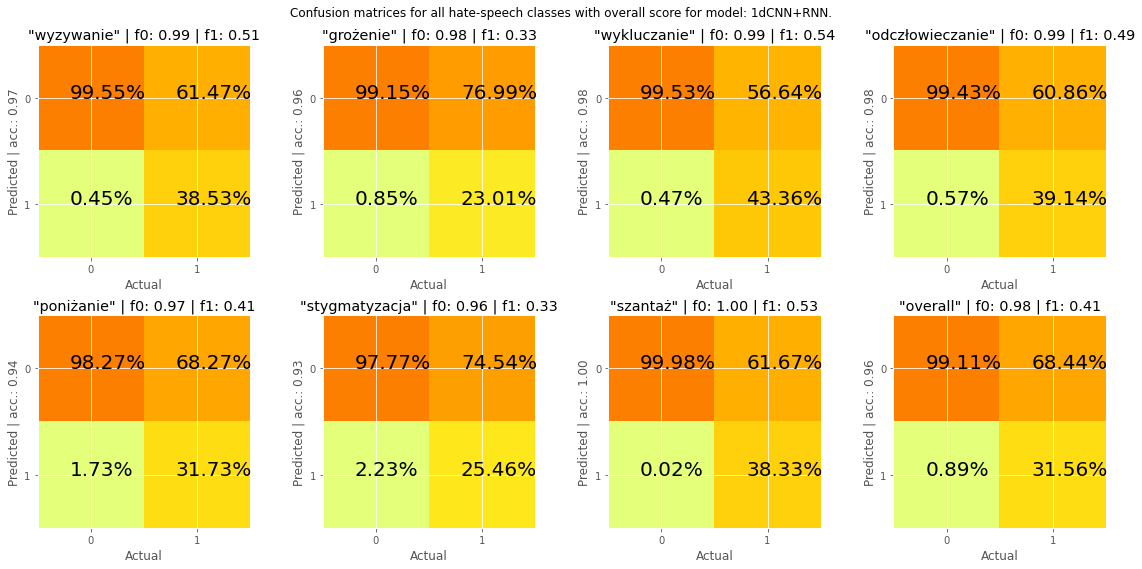

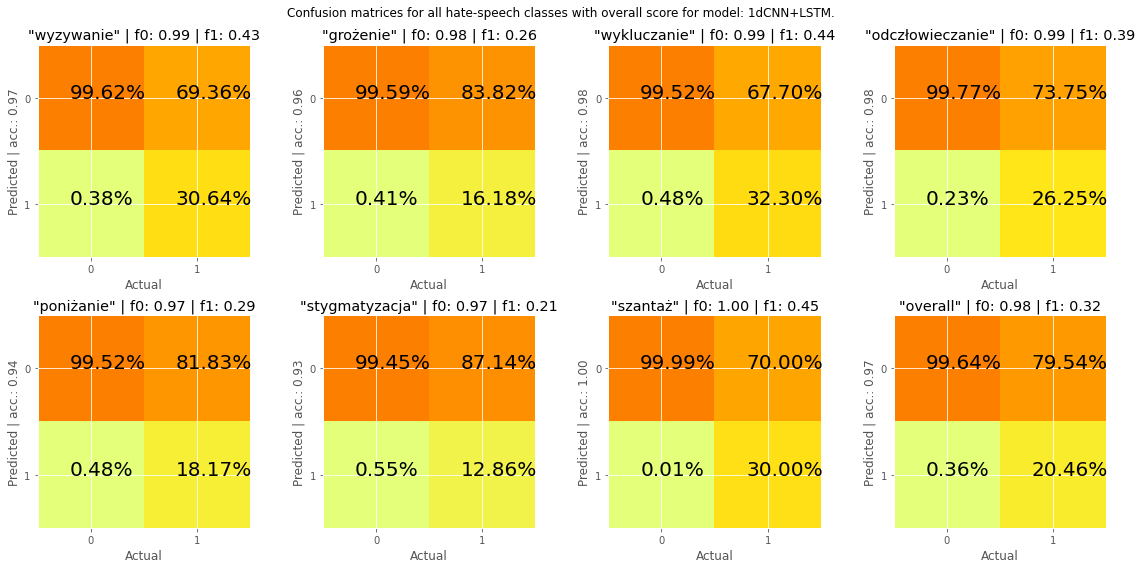

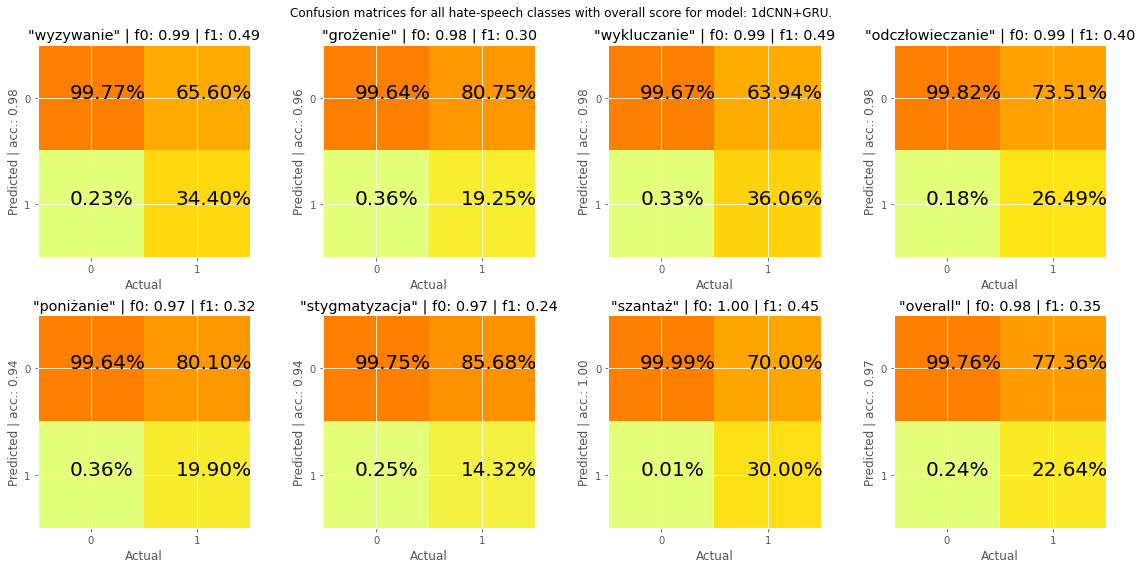

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/classifiers/DLVectorClassifier.py:123: RuntimeWarning: overflow encountered in exp
  return np.array([1/(1 + np.exp(-xx)) for xx in x])


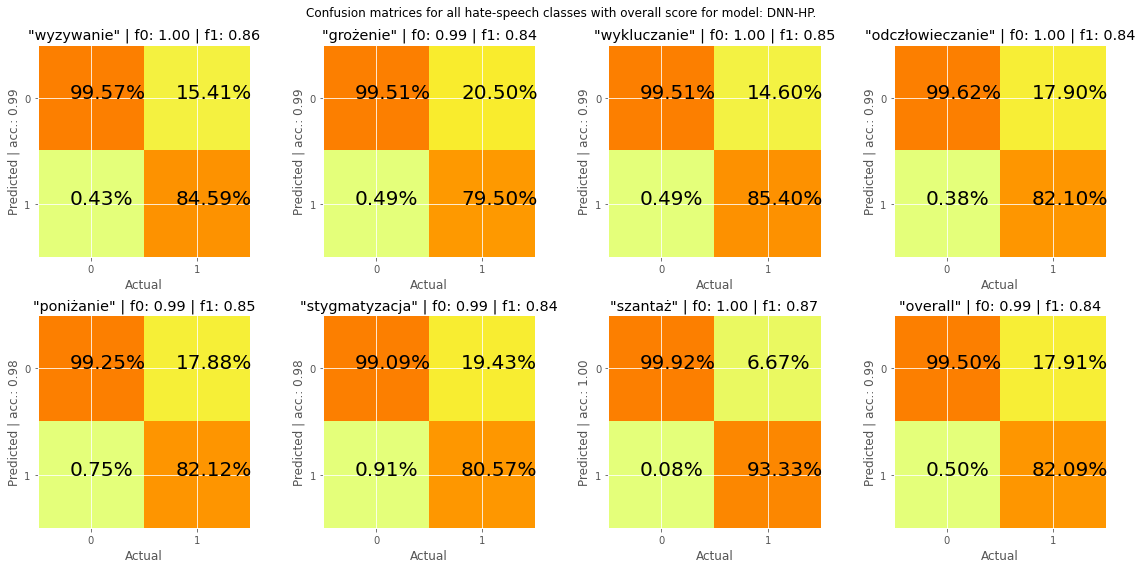

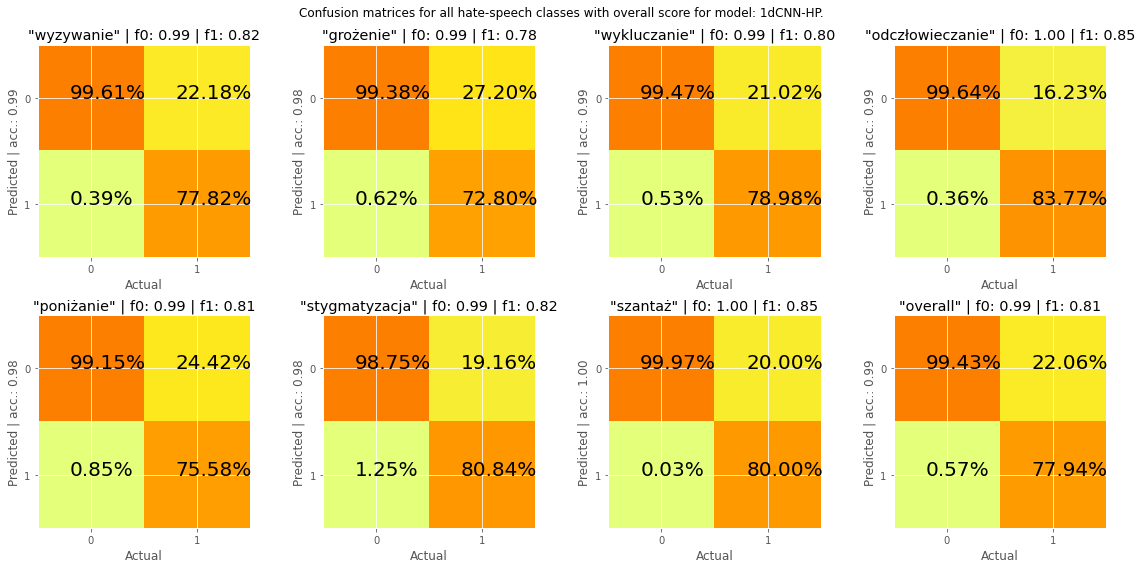

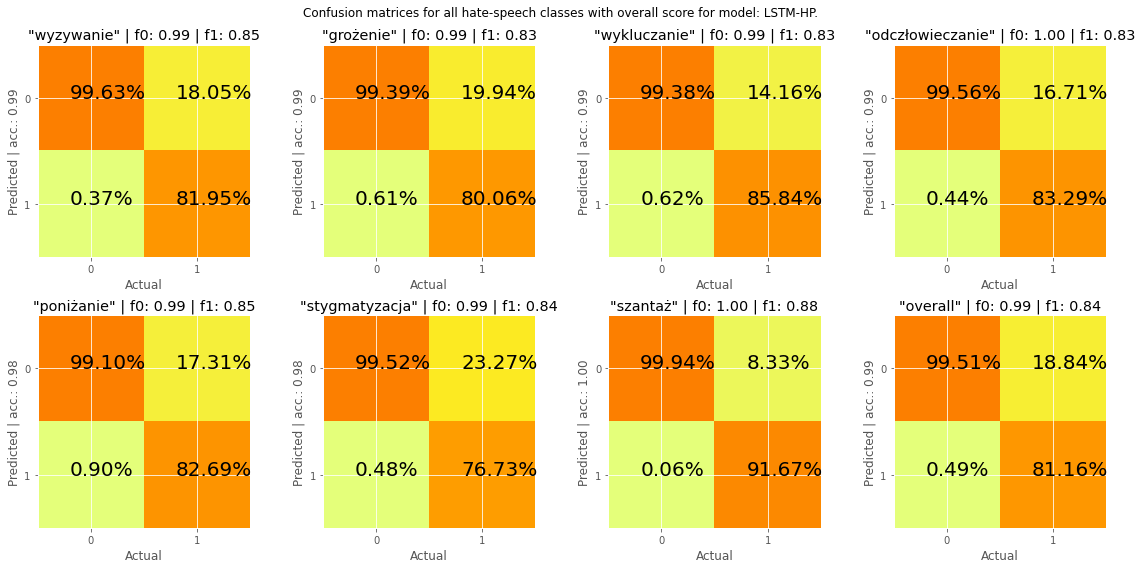

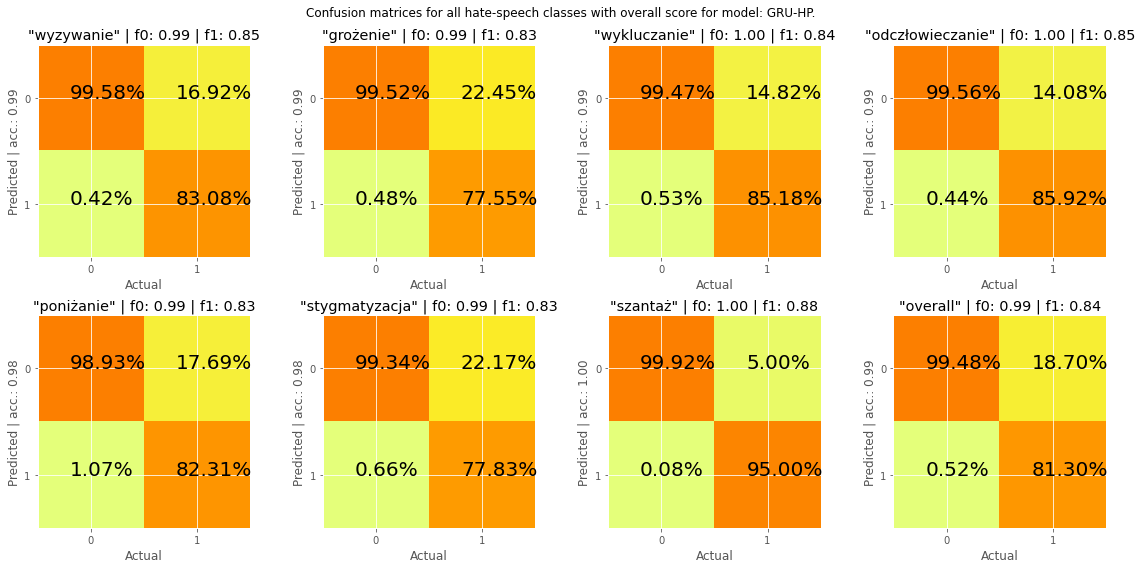

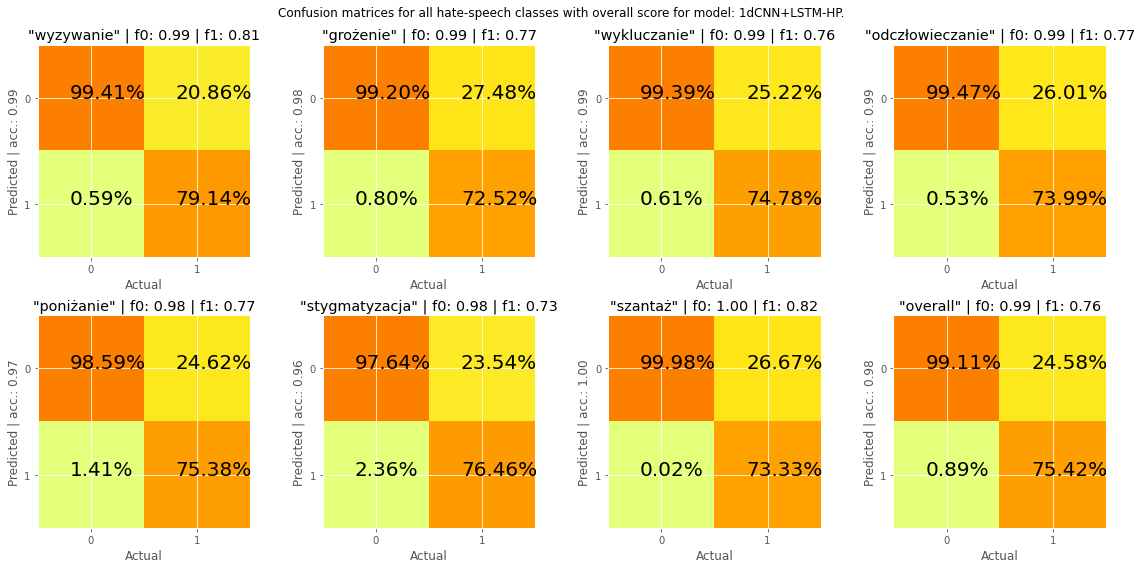

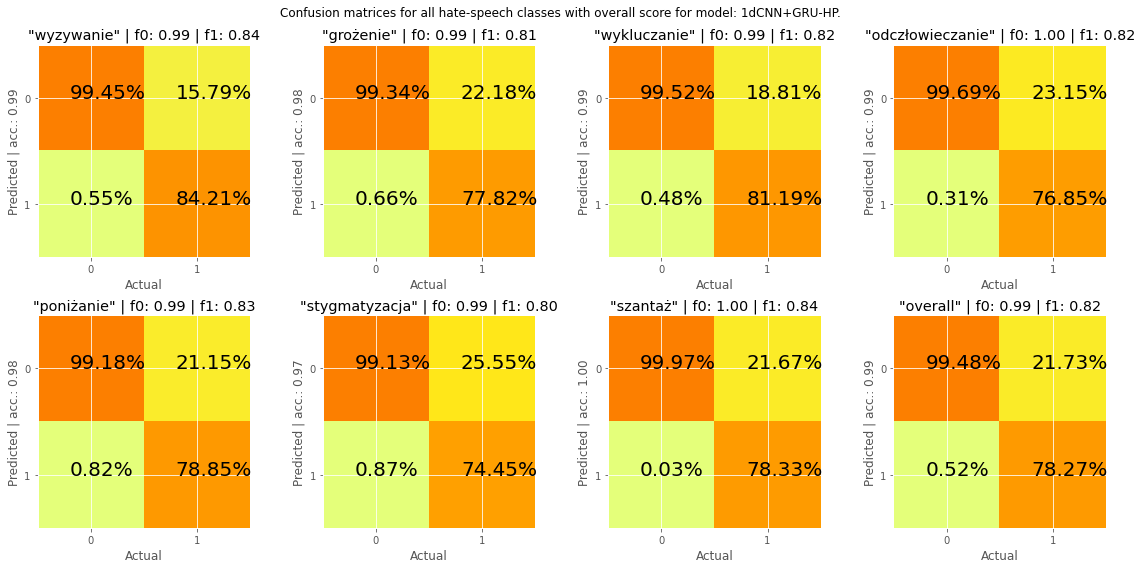

In [13]:
for clf_class, short_name, clf_kwargs in tqdm(zip(CLF_CLASSES, SHORT_NAMES, CLF_KWARGS),
                                              total=len(SHORT_NAMES), leave=False):
    if short_name == 'Lexical':
        X_data = df_lex_data.drop(LABELS, axis=1).values
        y_data = df_lex_data[LABELS].values
    elif short_name == 'RFFC':
        X_data = df_simpleML_data.drop(LABELS, axis=1).values
        y_data = df_simpleML_data[LABELS].values
    else:
        X_data = df_data.drop(LABELS, axis=1).values
        y_data = df_data[LABELS].values
        
    clf = clf_class(**clf_kwargs)
    clf.load()
    
    y_pred = clf.predict(X_data)
    confusion_matrices(y_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score for model: {short_name}.',
                       percentage=True, show_acc=True,
                       save_file=BEST_CHART_DIR.replace('{}', f'confusion_matrices_{short_name}'))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

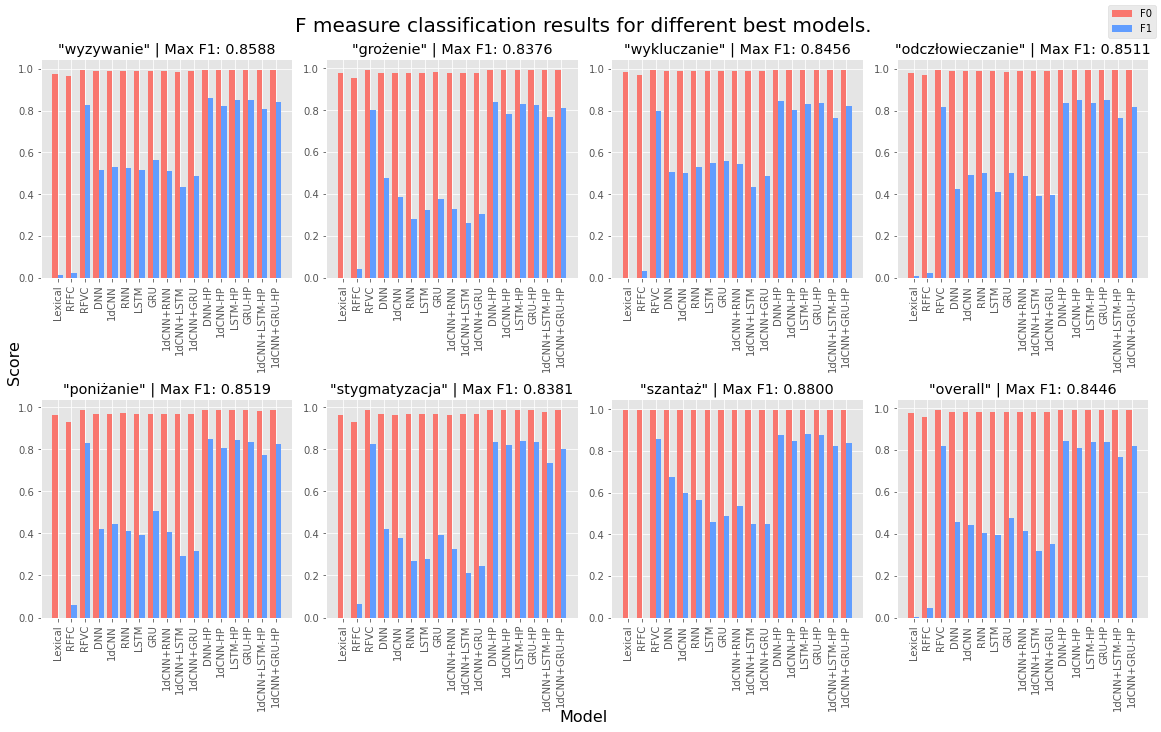

In [14]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                    title='F measure classification results for different best models.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=BEST_CHART_DIR.replace('{}', f'models_F_bars'))

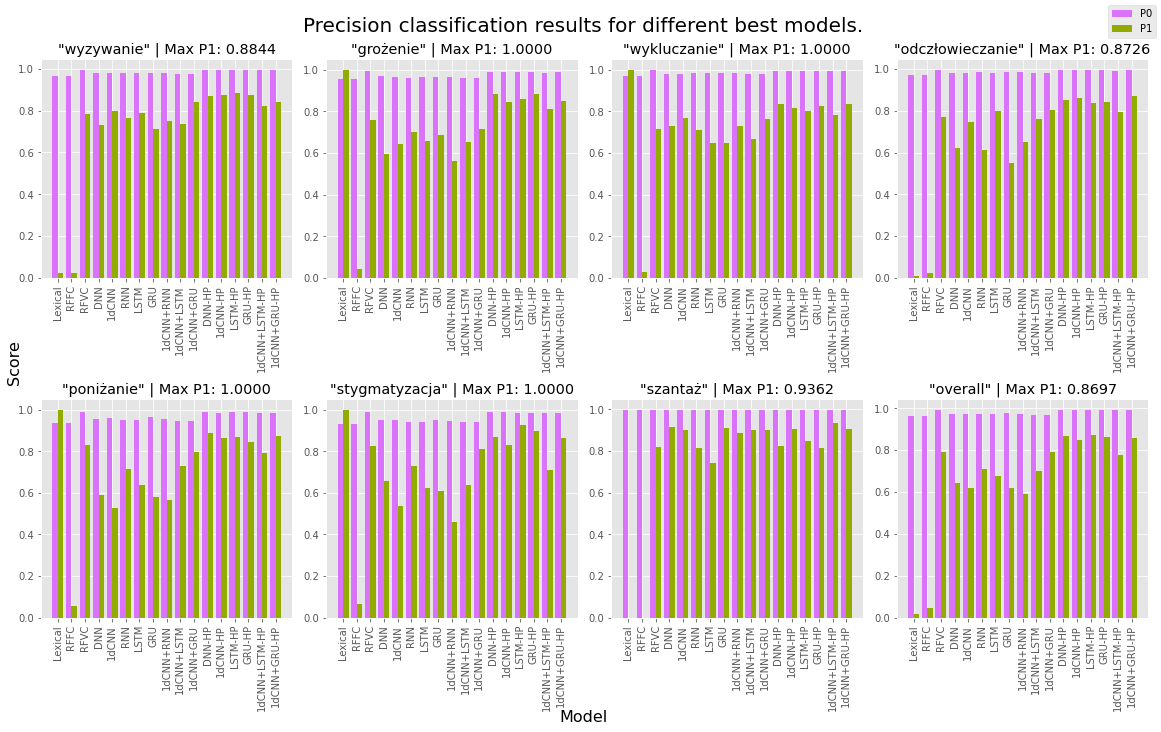

In [15]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                    title='Precision classification results for different best models.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=BEST_CHART_DIR.replace('{}', f'models_P_bars'))

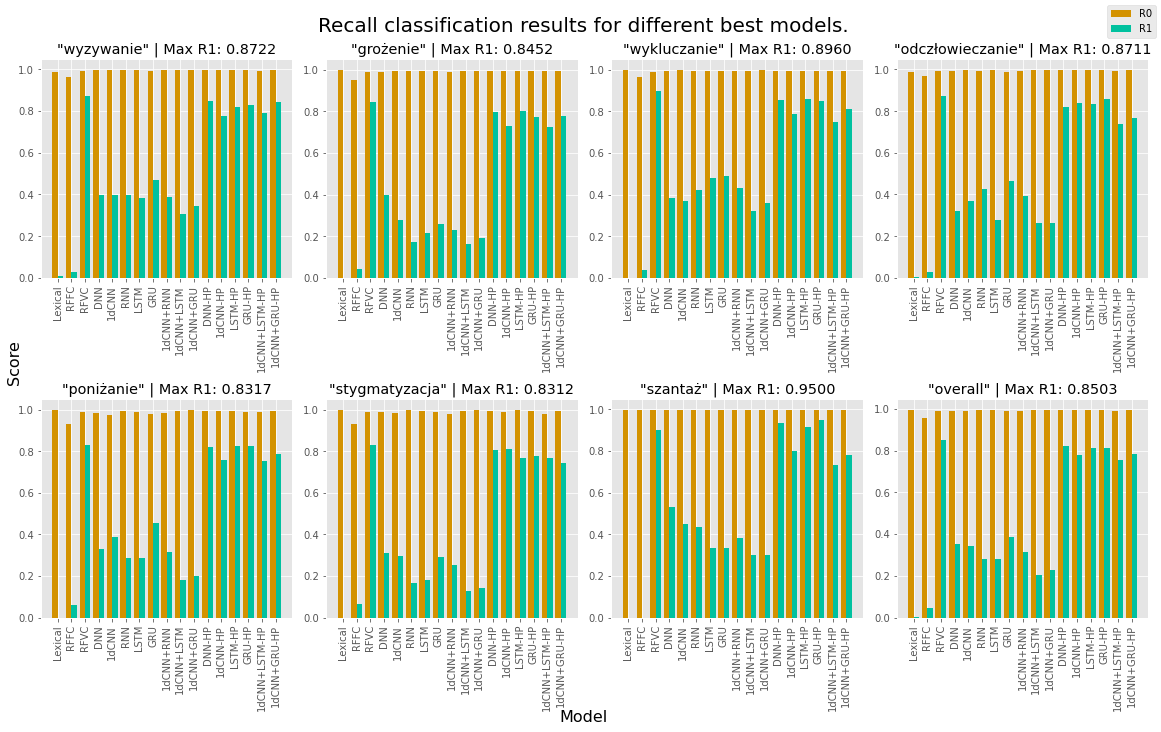

In [16]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                    title='Recall classification results for different best models.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=BEST_CHART_DIR.replace('{}', f'models_R_bars'))

## Best models results

In [20]:
models_quality_results(y_trues=y_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                       additionals=[NAMES, TYPES, PARAMETERS],
                       additional_titles=['name', 'type', 'classifier parameters'],
                       save_file=RESULTS_DIR.replace('{}', 'best_models_results'))

,wyzywanie_A,wyzywanie_P0,wyzywanie_P1,wyzywanie_R0,wyzywanie_R1,wyzywanie_F0,wyzywanie_F1,grożenie_A,grożenie_P0,grożenie_P1,...,overall_A,overall_P0,overall_P1,overall_R0,overall_R1,overall_F0,overall_F1,name,type,classifier parameters
model,,,,,,,,,,,,,,,,,,,,,
Lexical,0.954214,0.966196,0.024876,0.987155,0.009398,0.976563,0.013643,0.954594,0.954594,1.000000,...,0.957200,0.960866,0.016317,0.996027,0.001622,0.978131,0.002950,Lexical Classifier,lexical,{}
RFFC,0.931607,0.965955,0.024306,0.963169,0.026316,0.964560,0.025271,0.910202,0.954352,0.040629,...,0.922940,0.961198,0.044647,0.958502,0.047729,0.959848,0.046137,Random Forest Feature Classifier,simple machine learning,{criterion: gini}
RFVC,0.987525,0.995526,0.782462,0.991546,0.872180,0.993532,0.824889,0.980749,0.992596,0.758448,...,0.985317,0.993899,0.789757,0.990802,0.850324,0.992348,0.818922,Random Forest Vector Classifier,simple machine learning,{criterion: gini}
DNN,0.974796,0.979356,0.731034,0.994888,0.398496,0.987061,0.515815,0.960357,0.971848,0.594595,...,0.967142,0.974189,0.644670,0.992092,0.353105,0.983059,0.456287,Dense Neural Network Classifier,simple deep learning,"{hidden size: 500, dropout: 0., dense layers: 1}"
1dCNN,0.976316,0.979326,0.799242,0.996527,0.396617,0.987852,0.530151,0.960231,0.966542,0.644013,...,0.966156,0.973804,0.620243,0.991452,0.343605,0.982549,0.442225,1D Convolutional Neural Network Classifier,simple deep learning,"{channels: 32, kernel size: 3, conv. layers: 2}"
RNN,0.975619,0.979373,0.765343,0.995740,0.398496,0.987489,0.524104,0.959154,0.962083,0.702247,...,0.967396,0.971503,0.707218,0.995265,0.281511,0.983240,0.402718,Simple Recurrent Neural Network Classifier,simple deep learning,"{rec. layers: 1, dropout: 0.1, bidirectional: ..."
LSTM,0.975746,0.978882,0.787645,0.996396,0.383459,0.987561,0.515803,0.959281,0.963811,0.658120,...,0.966618,0.971368,0.676040,0.994577,0.278499,0.982836,0.394486,LSTM Neural Network Classifier,simple deep learning,"{rec. layers: 1, dropout: 0., bidirectional: F..."
GRU,0.975682,0.981735,0.710227,0.993315,0.469925,0.987491,0.565611,0.960990,0.965726,0.687732,...,0.966771,0.975375,0.620097,0.990426,0.384615,0.982843,0.474760,GRU Neural Network Classifier,simple deep learning,"{rec. layers: 1, dropout: 0., bidirectional: T..."
1dCNN+RNN,0.974922,0.978926,0.748175,0.995478,0.385338,0.987133,0.508685,0.956937,0.964383,0.563140,...,0.964754,0.972707,0.591146,0.991132,0.315570,0.981833,0.411480,1D Convolutional Recurrent Neural Network Clas...,complex deep learning,"{channels: 32, hidden size: 100, bidirectional..."


## Three best of best models

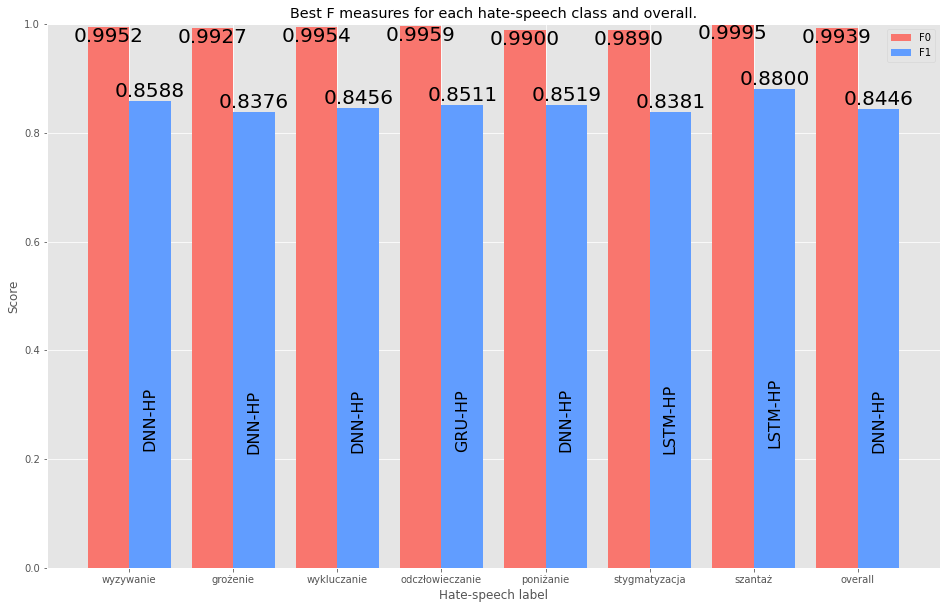

In [18]:
best_model_for_class(y_trues=y_data, y_preds_s=y_preds, model_names=SHORT_NAMES,
                     title='Best F measures for each hate-speech class and overall.',
                     save_file=BEST_CHART_DIR.replace('{}', f'best_F_bars'))

Judging by the above analyses the **3-rd** place took **GRU-HP** model, the **2-nd** - **LSTM-HP** and the **winner** is **DNN-HP** model.

## Comparison with bibliographical positions

| Bibliographical position / project                                                                                                           | Model / dataset              | Accuracy | Mean precision | Mean recall | Mean F measure |
|-------------------------------------------------------------------------------------------------------------------------------------------|------------------------------|----------|----------------|-------------|----------------|
| [,,Automatically Annotating A Five-Billion-Word Corpus<br />of Japanese Blogs for Affect and Sentiment Analysis''](https://www.aclweb.org/anthology/W12-3714.pdf)                               | ML-Ask                       | 90.00%   | 85.70%         | 54.70%      | n/a            |
| [,,A Survey on Hate Speech Detection using<br />Natural Language Processing''](https://www.aclweb.org/anthology/W17-1101.pdf)                                                                   | n/a                          | n/a      | n/a            | n/a         | n/a            |
| [,,Racial Bias in Hate Speech and<br />Abusive Language Detection Datasets''](https://www.aclweb.org/anthology/W19-3504.pdf)                                                                    | Waseem & Hoovy               | n/a      | 76.67%         | 79.00%      | 77.67%         |
| ----\|\|----                                                                                                                              | Waseem                       | n/a      | 67.25%         | 76.00%      | 71.25%         |
| ----\|\|----                                                                                                                              | Davidson et al.              | n/a      | 69.67%         | 53.33%      | 73.00%         |
| [,,Hateful Symbols or Hateful People?<br />Predictive Features for Hate Speech Detection on Twitter''](https://www.aclweb.org/anthology/N16-2013.pdf)                                           | word n-gram                  | n/a      | 64.39%         | 71.39%      | 64.58%         |
| ----\|\|----                                                                                                                              | character n-gram             | n/a      | 72.87%         | 77.75%      | 73.89%         |
| [,,Multi-label Hate Speech and Abusive Language<br />Detection in Indonesian Twitter''](https://www.aclweb.org/anthology/W19-3506.pdf)                                                          | word n-gram                  | 73.53%   | n/a            | n/a         | n/a            |
| ----\|\|----                                                                                                                              | character n-gram             | 72.44%   | n/a            | n/a         | n/a            |
| ----\|\|----                                                                                                                              | lexicon                      | 52.10%   | n/a            | n/a         | n/a            |
| [,,Results of the PolEval 2019 Shared Task 6:<br />first dataset and Open Shared Task for<br />automatic cyberbullying detection in Polish Twitter''](https://ruj.uj.edu.pl/xmlui/bitstream/handle/item/152265/ptaszynski_pieciukiewicz_dybala_results_of_the_poleval_2019.pdf?sequence=1&isAllowed=y) | n-waves ULMFiT               | 90.10%   | 66.67%         | 52.24%      | 58.58%         |
| ----\|\|----                                                                                                                              | LMFiT + SentencePiece        | 87.40%   | 52.90%         | 54.48%      | 53.68%         |
| ----\|\|----                                                                                                                              | ensemble spacy + tpot + BERT | 87.30%   | 52.71%         | 50.75%      | 51.71%         |
| **,,Hate Speech Detector 2.0''**                                                                                                              | lexical                      | 95.72%   | 48.73%         | 49.88%      | 49.06%         |
| ----\|\|----                                                                                                                              | Random Forest + FastText     | 98.53%   | 89.19%         | 92.06%      | 90.56%         |
| **----\|\|----**                                                                                                                              | **Dense NN + Word2Vec**          | **98.82%**   | **93.12%**         | **90.80%**      | **91.93%**         |
| ----\|\|----                                                                                                                              | LSTM NN + Word2Vec           | 98.79%   | 93.11%         | 90.34%      | 91.67%         |
| ----\|\|----                                                                                                                              | GRU NN + Word2Vec            | 98.77%   | 92.82%         | 90.39%      | 91.57%         |

The **best** hate speech detection model trained in project is **better than all** of the models presented in bibliographical positions.<br /> **THIS IS THE BASE FOR PUBLICATION!**